In [1]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import scipy.stats as stats
from matplotlib import gridspec
import aplpy as apl #The Astronomy Plotting Library for python
import astropy
from astropy.stats import sigma_clip
from astropy.modeling import functional_models, models, fitting
import astropy.units as U
from astropy.coordinates import ICRS, Galactic, FK4, FK5, Angle, Latitude, Longitude
import astropy.constants as C
from astropy import wcs
import astropy.io.fits as fits
from astropy.io import ascii
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.stats import signal_to_noise_oir_ccd as SNRas
#import spectral_cube as SC
#from spectral_cube import SpectralCube as sc
from astropy.wcs import WCS
matplotlib.use('Agg')
import matplotlib.cm as cm
#import astrometry as ast
import pyfits
import requests
import json
import os
from sklearn import datasets, linear_model
from scipy.optimize import curve_fit
import numpy.ma as ma
from astropy.table import Table, Column
import pyextract
import sewpy
import pandas as pd
from astropy import units as u
#import alipy

/home/lynge/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/lynge/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/lynge/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/lynge/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/lynge/anaconda2

In [2]:
quasJ = [os.path.join('/../home/lynge/MasterP/NGC3783/H',f) \
        for f in os.listdir('/../home/lynge/MasterP/NGC3783/H')]


qua1_RA_WORLD = 174.75717083
qua1_DEC_WORLD = -37.73850000
sta1_RA_WORLD = 174.77413750 - 9*10**(-5) #HD 101274
sta1_DEC_WORLD = -37.75375000 + 6.4*10**(-5)
sta2_RA_WORLD = 174.82283333 - 0.15/3600. #Tycho-2 7740-22-1
sta2_DEC_WORLD = -37.76239167
sta3_RA_WORLD = 174.79553333 #174.79553250 #Tycho-2 7740-529-1
sta3_DEC_WORLD = -37.83470278 #-37.83470333

sky1_RA_WORLD = SkyCoord('11:38:59 -37:44:44', unit=(u.hourangle, u.deg)).ra.degree #Random patch of sky
sky1_DEC_WORLD = SkyCoord('11:38:59 -37:44:44', unit=(u.hourangle, u.deg)).dec.degree

sky2_RA_WORLD = SkyCoord('11:39:04 -37:43:33', unit=(u.hourangle, u.deg)).ra.degree #Random patch of sky
sky2_DEC_WORLD = SkyCoord('11:39:04 -37:43:33', unit=(u.hourangle, u.deg)).dec.degree

sky3_RA_WORLD = SkyCoord('11:38:59 -37:43:51', unit=(u.hourangle, u.deg)).ra.degree #Random patch of sky
sky3_DEC_WORLD = SkyCoord('11:38:59 -37:43:51', unit=(u.hourangle, u.deg)).dec.degree

MAG_STA1_J = 8.997
MAG_STA1_H = 8.982
MAG_STA1_K = 8.909

MAG_STA2_J = 10.919
MAG_STA2_H = 10.726
MAG_STA2_K = 10.611

MAG_STA3_J = 9.902
MAG_STA3_H = 9.625
MAG_STA3_K = 9.580

MAG_err_STA1_J = 0.026
MAG_err_STA1_H = 0.023
MAG_err_STA1_K = 0.021

MAG_err_STA2_J = 0.026
MAG_err_STA2_H = 0.023
MAG_err_STA2_K = 0.024

MAG_err_STA3_J = 0.023
MAG_err_STA3_H = 0.022
MAG_err_STA3_K = 0.023

MAG_VEGA_B = 0.
MAG_VEGA_V = 0.
MAG_VEGA_G = 0.
MAG_VEGA_J = 0.
MAG_VEGA_H = 0.
MAG_VEGA_K = 0.

MAG_VEGA_g = 0.
MAG_VEGA_r = 0.
MAG_VEGA_i = 0.
MAG_VEGA_z = 0.

FLUX_LAMBDA_VEGA_B = 632*10**(-11) #erg/cm**2/s/A
FLUX_LAMBDA_VEGA_V = 363.1*10**(-11)
FLUX_LAMBDA_VEGA_G = float('nan')
FLUX_LAMBDA_VEGA_J = 3.14*10**(-10)
FLUX_LAMBDA_VEGA_H = 1.11*10**(-10)
FLUX_LAMBDA_VEGA_K = 4.29*10**(-11)

FLUX_LAMBDA_VEGA_g = 466.9*10**(-11) #erg/cm**2/s/A
FLUX_LAMBDA_VEGA_r = 278.0*10**(-11)
FLUX_LAMBDA_VEGA_i = 185.2*10**(-11)
FLUX_LAMBDA_VEGA_z = 131.5*10**(-11)


FLUX_V_VEGA_B = 4.063*10**(-20) #erg/cm**2/s/Hz
FLUX_V_VEGA_V = 3.636*10**(-20)
FLUX_V_VEGA_G = float('nan')
FLUX_V_VEGA_J = 1.589*10**(-20)
FLUX_V_VEGA_H = 1.021*10**(-20)
FLUX_V_VEGA_K = 0.64*10**(-20)

FLUX_V_VEGA_g = 3.631*10**(-20) #erg/cm**2/s/Hz
FLUX_V_VEGA_r = 3.631*10**(-20)
FLUX_V_VEGA_i = 3.631*10**(-20)
FLUX_V_VEGA_z = 3.631*10**(-20)


In [3]:
def dist(mid,end):
    return np.sqrt((mid[0] - end[0])**2 + (mid[1] - end[1])**2)

In [4]:
def flux_cal(A_mag,B_mag,B_flux):
    '''Flux of A found through magnitude and flux of B'''
    return B_flux*10**((B_mag-A_mag)/2.5)

In [5]:
def Basic(quasar,header):
    '''Provides a basic list of neccesities from the fits header file for use in the later \
    flux determination, it does not serve an individual purpose beyound that'''
    AGNdata = quasar #np.rot90(np.rot90(np.fliplr(quasar)))
    #header = data[0].header
    #print header
    RAstd = header['CRVAL1']
    DECstd = header['CRVAL2']
    #print RAstd, DECstd
    pixspa = header['PIXSCALE']/(3600.)
    #print pixspa
    RAstdpix = header['CRPIX1']
    DECstdpix = header['CRPIX2']
    exptime = 10 # header['EXPTIME']
    return header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime

In [6]:
def curve(quasar,header,w,center,apparature):
    '''Determines the FLUX of the stellar object given the the numpy array of the image, \
    the header of the fits file, the astropy coordinate representation, \
    the object position and the apparature of interest'''
    header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime = Basic(quasar,header)
    #AGNdata = np.swapaxes(AGNdata,0,1)
    y, x = np.ogrid[0:header['NAXIS1'],0:header['NAXIS1']]
    #w = np.swapaxes(w,0,1)
    #F_AGN = np.zeros((512,512,3)) #((int(2*apparature/pixspa)+1,int(2*apparature/pixspa)+1,3))
    #print center
    x1 = w.all_world2pix(center[0],center[1],0)
    x1,y1 = (x1[0]),(x1[1])
    if 15 < x1 < header['NAXIS1'] - 15 and 15 < y1 < header['NAXIS2'] - 15:
        try:
            mask = ((y-y1)**2 + (x-x1)**2) > (apparature/float(pixspa))**2
            AGNdata[mask] = float(0)
            mask = AGNdata == 0.
            rows = np.flatnonzero((~mask).sum(axis=1))
            cols = np.flatnonzero((~mask).sum(axis=0))
            AGNdata = AGNdata[rows.min():rows.max()+1, cols.min():cols.max()+1]
            #print apparature/float(pixspa)
        except:
            AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    else:
        AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    #if np.sum(AGNdata) < 500:
    #    AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    return AGNdata, x1, y1


In [7]:
def comp1(qua,sta):
    '''Code to determine the relation between the AGN and the Stellar flux as determined by either me \
    or by the SExtractor program respectively'''
    comp = qua/sta
    return comp

In [8]:
def SXtable(quas,aperture):
    header = pyfits.getheader(quas)
    phot_app = aperture*3600/header['PIXSCALE']
    np.set_printoptions(threshold=np.inf)
    sew = sewpy.SEW(params=['XMODEL_WORLD', 'YMODEL_WORLD', 'X2MODEL_WORLD', 'Y2MODEL_WORLD', 
                            'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_RADIUS(1)', 'FLUX_APER','ELLIPTICITY'],
                    config={"DETECT_THRESH":5, 'DETECT_MINAREA':5, 'DETECT_MAXAREA':10000, 
                            "PHOT_FLUXFRAC":"0.5", 'PHOT_APERTURES':2*phot_app, 
                            'PIXEL_SCALE':header['PIXSCALE']}
                    , sexpath='/usr/bin/sextractor')
    out = sew(quas)
    return out

In [9]:
def flux(quas,aperture,main_RA_WORLD,main_DEC_WORLD):
    header = pyfits.getheader(quas)
    RAmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[0]
    DECmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[1]
    output = float('nan')
    if 15 < RAmain < header['NAXIS1'] - 15 and 15 < DECmain < header['NAXIS2'] - 15: 
        out = SXtable(quas,aperture)
        RAmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,0)[0]
        DECmain = WCS(quas).all_world2pix(main_RA_WORLD,main_DEC_WORLD,0)[1]
        #print out['table']['XMODEL_IMAGE'], out['table']['YMODEL_IMAGE']
        #print RAmain, DECmain

        for j in range(len(out['table']['XMODEL_IMAGE'])):
            #output['time'][i] = header['MJD-OBS']
            if RAmain - 5. < out['table']['XMODEL_IMAGE'][j] <  RAmain + 5. and \
            DECmain - 5. < out['table']['YMODEL_IMAGE'][j] < DECmain + 5.:
                #print 'YES'
                output = out['table']['FLUX_APER'][j]
                break
    else:
        output = float('nan')
        #print 'Done'
    return output


In [10]:
def SNR(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float(header['GAIN'])*data1_2*header['DIT']*header['NDIT']/(np.sqrt
                                                        (float(header['GAIN'])*data1_2*header['DIT']*header['NDIT'] 
                                                         + float(header['GAIN'])*npix1*data2_2*header['DIT']
                                                         *header['NDIT']
                                                         +header['NDIT']*npix1*header['RON']**2))

def SNR11(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float(((header['GAIN'])*data1_2*header['DIT']*header['NDIT']))

def SNR22(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float(header['GAIN']*npix1*data2_2*header['DIT']*header['NDIT'])

def SNR33(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float((header['NDIT']*npix1*header['RON']**2))

def SNR44(data1,data2,header,ap1,ap2):
    npix1 = np.pi*ap1**2/((header['PIXSCALE']/3600.)**2)
    npix2 = np.pi*ap2**2/((header['PIXSCALE']/3600.)**2)
    #data2_1 = ((data2-data1)/npix2)*npix1
    data1_2 = data1
    data2_2 = abs(data2)
    
    return float(((header['GAIN'])*data1_2*header['DIT']*header['NDIT'] + 
                  header['GAIN']*npix1*data2_2*header['DIT']*header['NDIT'] +
                  header['NDIT']*npix1*header['RON']**2))

#SNRas(10.,data1_2,abs(data2_2),0,header['RON'],npix1,gain=header['GAIN'])

In [11]:
for i in range(len(quasJ)):
    data, header = fits.getdata(quasJ[i],header=True) #RA---TAN
    #print header['CTYPE2']
    #header['CTYPE1'] = "RA---TAN"
    #header['CTYPE2'] = "DEC--TAN"
    header['NDIT'] = 5
    '''header['A_ORDER'] = "0"
    header['B_ORDER'] = "0"
    header['AP_ORDER'] = "0"
    header['BP_ORDER'] = "0"
    header['A_0_2'] = "0"
    header['A_1_1'] = "0"
    header['A_2_0'] = "0"
    header['B_0_2'] = "0"
    header['B_1_1'] = "0"
    header['B_2_0'] = "0"
    header['AP_0_2'] = "0"
    header['AP_1_1'] = "0"
    header['AP_2_0'] = "0"
    header['AP_0_1'] = "0"
    header['AP_1_0'] = "0"
    header['BP_0_1'] = "0"
    header['BP_0_2'] = "0"
    header['BP_1_0'] = "0"
    header['BP_1_1'] = "0"
    header['BP_2_0'] = "0"'''
    fits.writeto(quasJ[i],data,header,clobber=True)
    #print fits.getheader(quasH[i])['A_ORDER']

In [12]:
def error(SIGNAL_AGN,SIGNAL_STAR,SNR_AGN,SNR_STAR,STAR_MAG,STAR_MAG_err,VEGA_FLUX,VEGA_MAG):
    
    SIGNAL_ERR = abs(SIGNAL_AGN/SIGNAL_STAR)*np.sqrt(SNR_AGN**(-2) + SNR_STAR**(-2))
    
    FLUX_CAL_ERR = STAR_MAG_err
    
    SIGNAL = VEGA_FLUX*10**((VEGA_MAG-STAR_MAG)/2.5)
    
    FLUX_CAL = abs(SIGNAL_AGN/SIGNAL_STAR)*VEGA_FLUX*((np.log(10)/2.5)*10**((VEGA_MAG - STAR_MAG)/2.5))
    
    return np.sqrt((SIGNAL**2*SIGNAL_ERR**2 + FLUX_CAL**2*FLUX_CAL_ERR**2))

In [13]:
def relerror(SIGNAL_AGN,SIGNAL_STAR,SNR_AGN,SNR_STAR,STAR_MAG,STAR_MAG_err,VEGA_FLUX,VEGA_MAG):
    
    SIGNAL_ERR = abs(SIGNAL_AGN/SIGNAL_STAR)*np.sqrt(SNR_AGN**(-2) + SNR_STAR**(-2))
    
    SIGNAL = VEGA_FLUX*10**((VEGA_MAG-STAR_MAG)/2.5)
    
    return np.sqrt((SIGNAL**2*SIGNAL_ERR**2))

In [14]:
def SEXAGNflux(quas,aperture1):
    aperture2 = aperture1 + 0.003
    date = []
    flucompsta1 = []
    flucompsta2 = []
    flucompsta3 = []
    flucompsta4 = []
    flucompsta5 = []
    flucompsta6 = []
    flucompsta7 = []
    poissonAGN = []
    poisson529 = []
    poisson22 = []
    poissonHD = []
    ABS_FLUX_LAMBDA_1 = 0
    ABS_FLUX_LAMBDA_2 = 0
    ABS_FLUX_LAMBDA_3 = 0
    ABS_FLUX_V_1 = 0
    ABS_FLUX_V_2 = 0
    ABS_FLUX_V_3 = 0
    SNR_comp = []
    comp_array = np.zeros((len(quas),6))
    SNR_array = np.zeros((len(quas),8))
    SNR_part = np.zeros((len(quas),5))
    SNR_star = np.zeros((len(quas),4))
    noise_quasar = np.zeros((len(quas),7))
    signal = np.zeros((len(quas),4))
    #-----------------------------------------------------------------------------------------------
    for i in range(len(quas)):
        print 'Frame nr. ', i, quas[i]
        header = pyfits.getheader(quas[i])
        a_AGN = flux(quas[i],2*aperture1,qua1_RA_WORLD,qua1_DEC_WORLD)/header['DIT']
        a2 = flux(quas[i],2*aperture1,sta1_RA_WORLD,sta1_DEC_WORLD)/header['DIT']
        a3 = flux(quas[i],2*aperture1,sta2_RA_WORLD,sta2_DEC_WORLD)/header['DIT']
        a4 = flux(quas[i],2*aperture1,sta3_RA_WORLD,sta3_DEC_WORLD)/header['DIT']
        a_sky1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sky1_RA_WORLD,sky1_DEC_WORLD),aperture1)[0]/header['DIT']
        a_sky2 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sky2_RA_WORLD,sky2_DEC_WORLD),aperture1)[0]/header['DIT']
        a_sky3 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sky3_RA_WORLD,sky3_DEC_WORLD),aperture1)[0]/header['DIT']
        #a_AGN_1 = flux(quas[i],2*aperture2,qua1_RA_WORLD,qua1_DEC_WORLD)/header['DIT']
        #a2_1 = flux(quas[i],2*aperture2,sta1_RA_WORLD,sta1_DEC_WORLD)/header['DIT']
        #a3_1 = flux(quas[i],2*aperture2,sta2_RA_WORLD,sta2_DEC_WORLD)/header['DIT']
        #a4_1 = flux(quas[i],2*aperture2,sta3_RA_WORLD,sta3_DEC_WORLD)/header['DIT']
        signal[i,0] = a_AGN
        signal[i,1] = a2
        signal[i,2] = a3
        signal[i,3] = a4
        #-------------------------------------------------------------------------------------------
        #plt.figure(figsize=(3,3))
        #plt.imshow(a2)
        #plt.show()
        #-------------------------------------------------------------------------------------------
        a_AGN_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a2_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a3_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a4_pix = np.pi*(aperture1)**2/((header['PIXSCALE']/3600.)**2)
        a_sky_pix = np.count_nonzero(a_sky1)
        a_sky_2 = np.sum(a_sky1)/float(np.count_nonzero(a_sky1))
        a_sky = np.concatenate((a_sky1.ravel(),a_sky2.ravel(),a_sky3.ravel()),axis=0)
        a_sky_var = np.nanvar(a_sky)
        print a_sky_2,a_sky_var
        #a_AGN_pix_1 = np.pi*(2*aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a2_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a3_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a4_pix_1 = np.pi*(aperture2)**2/((header['PIXSCALE']/3600.)**2)
        #a_AGN_2 = (np.sum(a_AGN_1) - np.sum(a_AGN))/(float(np.count_nonzero(a_AGN_1)) - float(np.count_nonzero(a_AGN)))
        #a2_2 = (np.sum(a2_1) - np.sum(a2))/(float(np.count_nonzero(a2_1)) - float(np.count_nonzero(a2)))
        #a3_2 = (np.sum(a3_1) - np.sum(a3))/(float(np.count_nonzero(a3_1)) - float(np.count_nonzero(a3)))
        #a4_2 = (np.sum(a4_1) - np.sum(a4))/(float(np.count_nonzero(a4_1)) - float(np.count_nonzero(a4)))
        a_AGN_3 = a_AGN/a_AGN_pix #- (a_AGN_1 - a_AGN)/(a_AGN_pix_1 - a_AGN_pix) #Background subtracted flux/pixel/sec
        a2_3 = a2/a2_pix #- (a2_1 - a2)/(a2_pix_1 - a2_pix)
        a3_3 = a3/a3_pix #- (a3_1 - a3)/(a3_pix_1 - a3_pix)
        a4_3 = a4/a4_pix #- (a4_1 - a4)/(a4_pix_1 - a4_pix)
        #-------------------------------------------------------------------------------------------
        date.append(header['MJD-OBS'])
        #-------------------------------------------------------------------------------------------
        poissonAGN.append(np.sqrt(np.sum(a_AGN)*header['DIT']*header['GAIN'])) #header['DIT']))
        poissonHD.append(np.sqrt(np.sum(a2)*header['DIT']*header['GAIN'])) #header['DIT']))
        poisson22.append(np.sqrt(np.sum(a3)*header['DIT']*header['GAIN'])) #header['DIT']))
        poisson529.append(np.sqrt(np.sum(a4)*header['DIT']*header['GAIN'])) #header['DIT']))
        #-------------------------------------------------------------------------------------------
        #if SNR1[i] < 70:
        #    flucompsta_AGN.append(float('nan'))
        #    flucompsta2.append(float('nan'))
        #    flucompsta3.append(float('nan'))
        #    flucompsta4.append(float('nan'))
        #    flucompsta6.append(float('nan'))
        #    comp_array[i,0] = int(date[i])
        #    comp_array[i,1] = float('nan')
        #    comp_array[i,2] = float('nan')
        #    comp_array[i,3] = float('nan')
        #else:
        flucompsta1.append(comp1(a_AGN_3,a2_3))
        flucompsta2.append(comp1(a_AGN_3,a3_3))
        flucompsta3.append(comp1(a_AGN_3,a4_3))
        SNR1 = SNR(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
        #flucompsta4.append(comp1(a_AGN_3,a5_3))
        #flucompsta5.append(comp1(a_AGN_3,a6_3))
        #flucompsta6.append(comp1(a_AGN_3,a7_3))
        comp_array[i,0] = int(date[i])
        comp_array[i,1] = flucompsta1[i]
        comp_array[i,2] = flucompsta2[i]
        comp_array[i,3] = flucompsta3[i]
        comp_array[i,4] = SNR1
        comp_array[i,5] = a_AGN
        #comp_array[i,5] = flucompsta5[i]
        #comp_array[i,6] = flucompsta6[i]
        print a_AGN, a2, a3, a4
        SNR_part[i,0] = date[i]
        SNR_part[i,1] = SNR(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
        SNR_part[i,2] = SNR11(a_AGN,np.sum(a_sky),header,aperture1,aperture1)\
        /SNR44(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
        SNR_part[i,3] = SNR22(a_AGN,np.sum(a_sky),header,aperture1,aperture1)\
        /SNR44(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
        SNR_part[i,4] = SNR33(a_AGN,np.sum(a_sky),header,aperture1,aperture1)\
        /SNR44(a_AGN,np.sum(a_sky),header,aperture1,aperture1)
        SNR_star[i,0] = header['MJD-OBS']
        SNR_star[i,1] = SNR(a2,np.sum(a_sky),header,aperture1,aperture1)
        SNR_star[i,2] = SNR(a3,np.sum(a_sky),header,aperture1,aperture1)
        SNR_star[i,3] = SNR(a4,np.sum(a_sky),header,aperture1,aperture1)
        noise_quasar[i,0] = header['MJD-OBS']
        noise_quasar[i,1] = float('nan')
        noise_quasar[i,2] = float('nan')
        noise_quasar[i,3] = float('nan')
        #SNR_array[i,0] = int(date[i])
        #SNR_array[i,1] = SNR(a_AGN,a_sky,header,aperture1,aperture1)
        #SNR_array[i,2] = SNR(a2,a_sky,header,aperture1,aperture1)
        #SNR_array[i,3] = SNR(a3,a_sky,header,aperture1,aperture1)
        #SNR_array[i,4] = SNR(a4,a_sky,header,aperture1,aperture1)
        #SNR_array[i,5] = SNR(a5,a_sky,header,aperture1,aperture1)
        #SNR_array[i,6] = SNR(a6,a_sky,header,aperture1,aperture1)
        #SNR_array[i,7] = SNR(a7,a_sky,header,aperture1,aperture1)
    #print 'YES'
    #-----------------------------------------------------------------------------------------------
    poissonAGN = np.array(poissonAGN)
    poissonHD = np.array(poissonHD)
    poisson22 = np.array(poisson22)
    poisson529 = np.array(poisson529)
    comp_array = comp_array[comp_array[:,0].argsort()]
    
    comp_array[:,1] = comp_array[:,1]*flux_cal(MAG_STA1_H,MAG_VEGA_H,FLUX_LAMBDA_VEGA_H)
    comp_array[:,2] = comp_array[:,2]*flux_cal(MAG_STA2_H,MAG_VEGA_H,FLUX_LAMBDA_VEGA_H)
    comp_array[:,3] = comp_array[:,3]*flux_cal(MAG_STA3_H,MAG_VEGA_H,FLUX_LAMBDA_VEGA_H)
    
    noise_quasar[:,1] = error(signal[:,0],signal[:,1],SNR_part[:,1],SNR_star[:,1],MAG_STA1_H,\
                              MAG_err_STA1_H,FLUX_LAMBDA_VEGA_H,MAG_VEGA_H)
    noise_quasar[:,2] = error(signal[:,0],signal[:,2],SNR_part[:,1],SNR_star[:,2],MAG_STA2_H,\
                              MAG_err_STA2_H,FLUX_LAMBDA_VEGA_H,MAG_VEGA_H)
    noise_quasar[:,3] = error(signal[:,0],signal[:,3],SNR_part[:,1],SNR_star[:,3],MAG_STA3_H,\
                              MAG_err_STA3_H,FLUX_LAMBDA_VEGA_H,MAG_VEGA_H)
    
    noise_quasar[:,4] = relerror(signal[:,0],signal[:,1],SNR_part[:,1],SNR_star[:,1],MAG_STA1_H,\
                              MAG_err_STA1_H,FLUX_LAMBDA_VEGA_H,MAG_VEGA_H)
    noise_quasar[:,5] = relerror(signal[:,0],signal[:,2],SNR_part[:,1],SNR_star[:,2],MAG_STA2_H,\
                              MAG_err_STA2_H,FLUX_LAMBDA_VEGA_H,MAG_VEGA_H)
    noise_quasar[:,6] = relerror(signal[:,0],signal[:,3],SNR_part[:,1],SNR_star[:,3],MAG_STA3_H,\
                              MAG_err_STA3_H,FLUX_LAMBDA_VEGA_H,MAG_VEGA_H)

    #-----------------------------------------------------------------------------------------------
    return comp_array,SNR_array,ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,\
ABS_FLUX_V_1,ABS_FLUX_V_2,ABS_FLUX_V_3,date,SNR_part,SNR_star,noise_quasar

In [15]:
comp_array,SNR_array,ABS_FLUX_LAMBDA_1_1,ABS_FLUX_LAMBDA_2_1,ABS_FLUX_LAMBDA_3_1,\
ABS_FLUX_V_1_1,ABS_FLUX_V_2_1,ABS_FLUX_V_3_1,date_1,SNR_part_1,SNR_star_1,noise_quasar_1 = SEXAGNflux(quasJ,0.0002)

Frame nr.  0 /../home/lynge/MasterP/NGC3783/H/106NGC3783H.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
No handlers could be found for logger "sewpy.sewpy"


0.6 1.5968749999999998
972.8606 6159.346 1371.115 nan
Frame nr.  1 /../home/lynge/MasterP/NGC3783/H/70NGC3783H.fits
-0.8 0.0
575.7318 2640.825 573.5335 nan
Frame nr.  2 /../home/lynge/MasterP/NGC3783/H/113NGC3783H.fits
-0.7 0.106875
325.649 1211.545 nan nan
Frame nr.  3 /../home/lynge/MasterP/NGC3783/H/97NGC3783H.fits
nan 0.1225
690.1724 2663.433 636.1567 1588.701
Frame nr.  4 /../home/lynge/MasterP/NGC3783/H/94NGC3783H.fits
-1.6 0.5
786.4827 3818.29 nan nan
Frame nr.  5 /../home/lynge/MasterP/NGC3783/H/114NGC3783H.fits
-0.4 0.32249999999999995
255.3381 963.3896000000001 251.41019999999997 nan
Frame nr.  6 /../home/lynge/MasterP/NGC3783/H/102NGC3783H.fits
-1.0 0.16499999999999998
300.8504 1648.602 331.38980000000004 814.3518
Frame nr.  7 /../home/lynge/MasterP/NGC3783/H/72NGC3783H.fits
-0.6 0.028888888888888884
729.4992 3409.496 789.0376 nan
Frame nr.  8 /../home/lynge/MasterP/NGC3783/H/59NGC3783H.fits
0.1 0.006666666666666665
492.20079999999996 1596.523 366.65819999999997 1007.835
Fra

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


0.44999999999999996 0.031874999999999994
nan nan nan nan
Frame nr.  35 /../home/lynge/MasterP/NGC3783/H/110NGC3783H.fits
0.05 1.186875
815.0824 3662.314 741.8352 nan
Frame nr.  36 /../home/lynge/MasterP/NGC3783/H/78NGC3783H.fits
-1.4 1.731875
622.8702000000001 2920.1549999999997 634.7656 nan
Frame nr.  37 /../home/lynge/MasterP/NGC3783/H/107NGC3783H.fits
-1.2 0.7222222222222223
333.9093 741.4201 295.722 904.9983
Frame nr.  38 /../home/lynge/MasterP/NGC3783/H/69NGC3783H.fits
nan 0.0
610.4963 2803.105 631.796 1690.532
Frame nr.  39 /../home/lynge/MasterP/NGC3783/H/61NGC3783H.fits
-1.3 0.0688888888888889
893.2760000000001 4729.625 nan nan
Frame nr.  40 /../home/lynge/MasterP/NGC3783/H/67NGC3783H.fits
-0.8 0.136875
503.4016 1850.8790000000001 383.6812 nan
Frame nr.  41 /../home/lynge/MasterP/NGC3783/H/68NGC3783H.fits
-0.75 1.481875
542.8722 1472.788 314.23850000000004 nan
Frame nr.  42 /../home/lynge/MasterP/NGC3783/H/101NGC3783H.fits
-0.4 0.10888888888888891
871.4736 4795.347 nan nan
Fram

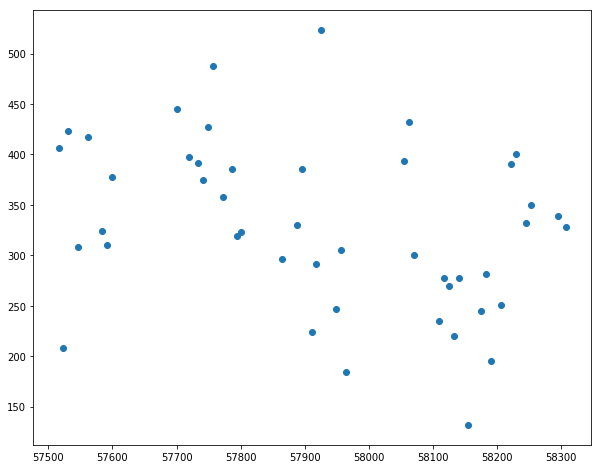

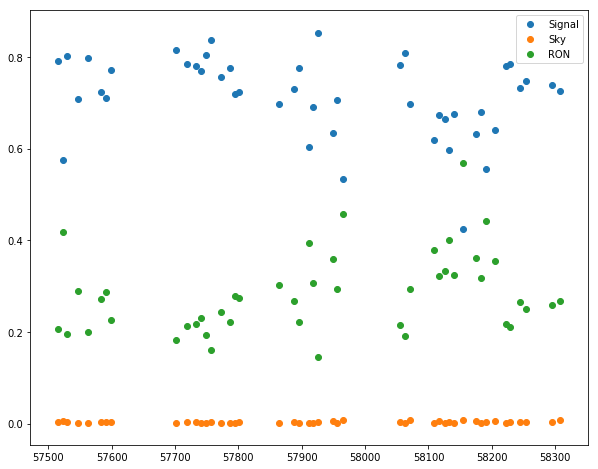

[445.27108289          nan 220.35788506          nan 391.56734337
 184.66527273 208.12446983 374.38645604 291.79279749 277.43584854
 234.83591861 323.48957666 427.37467307 131.78389817          nan
 308.23800289          nan 357.38814838          nan 406.57747226
 328.05469334 487.77636664 523.73433082          nan 390.3522531
 393.53315056 300.60591429 324.23357487          nan          nan
 251.18816523 330.00023381 319.23888911 385.71274157          nan
 400.04581031 339.06865483 224.39008662          nan 423.0134141
 296.08842522 310.61414635 416.97204114 304.81845611          nan
          nan 195.07660956 432.00898499 397.35094944 385.16042105
          nan          nan          nan 349.49535254 331.63298383
 269.41832133          nan 246.8578669           nan 378.11398707
 281.85178743 277.35888153          nan          nan          nan
 245.25097632]


In [16]:
plt.figure(figsize=(10,8))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,1])
plt.show()

plt.figure(figsize=(10,8))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,2],label='Signal')
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,3],label='Sky')
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,4],label='RON')
plt.legend()
#plt.ylim([5*10**(-15),1.*10**(-14)])
plt.show()

print SNR_part_1[:,1]


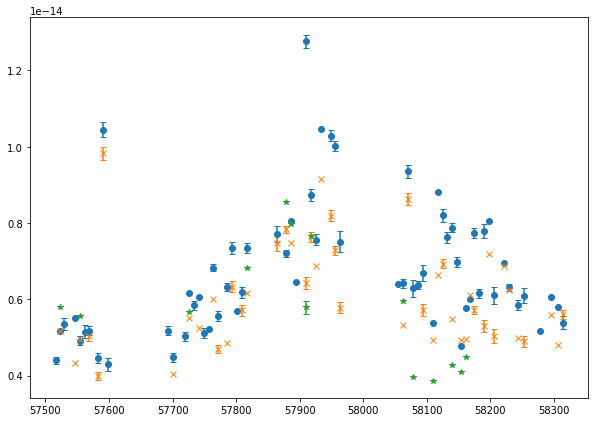

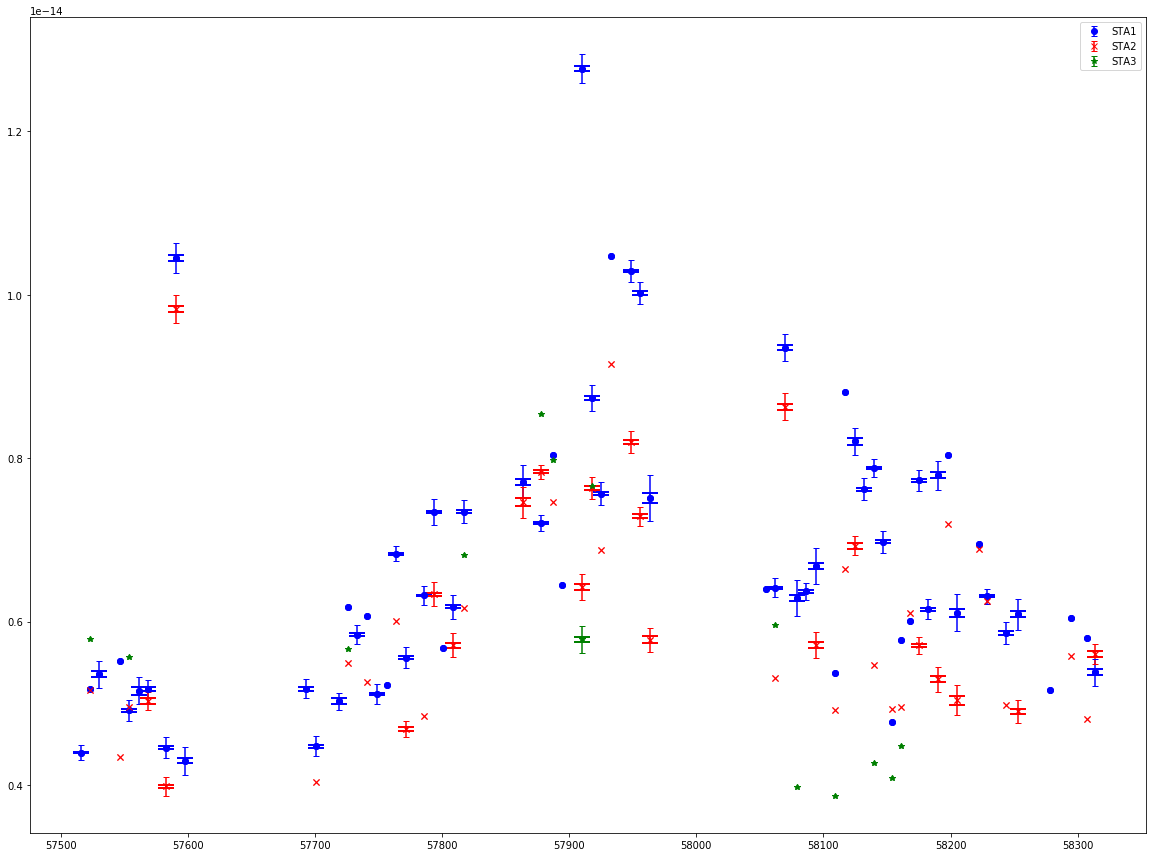

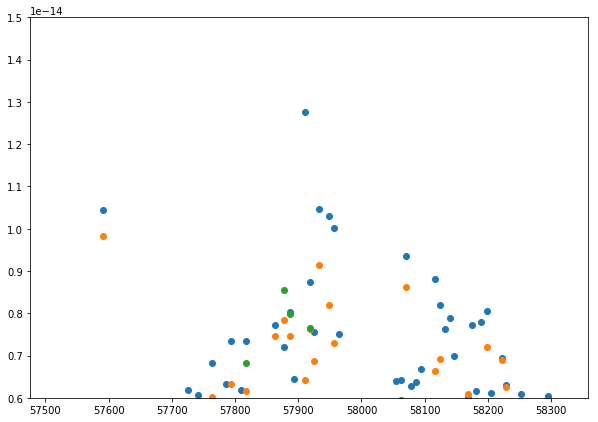

In [17]:

plt.figure(figsize=(10,7))
plt.errorbar(comp_array[:,0],comp_array[:,1],yerr=noise_quasar_1[:,1],fmt='o',capsize=3)
plt.errorbar(comp_array[:,0],comp_array[:,2],yerr=noise_quasar_1[:,2],fmt='x',capsize=3)
plt.errorbar(comp_array[:,0],comp_array[:,3],yerr=noise_quasar_1[:,3],fmt='*',capsize=3)
#plt.ylim([3*10**(-15),0.45*10**(-14)])
plt.show()

plt.figure(figsize=(20,15))
plt.errorbar(comp_array[:,0],comp_array[:,1],yerr=noise_quasar_1[:,1],fmt='o',capsize=3,color='b',label='STA1')
plt.errorbar(comp_array[:,0],comp_array[:,2],yerr=noise_quasar_1[:,2],fmt='x',capsize=3,color='r',label='STA2')
plt.errorbar(comp_array[:,0],comp_array[:,3],yerr=noise_quasar_1[:,3],fmt='*',capsize=3,color='g',label='STA3')
plt.errorbar(comp_array[:,0],comp_array[:,1],yerr=noise_quasar_1[:,4],fmt='o',capsize=8,capthick=2,color='b')
plt.errorbar(comp_array[:,0],comp_array[:,2],yerr=noise_quasar_1[:,5],fmt='x',capsize=8,capthick=2,color='r')
plt.errorbar(comp_array[:,0],comp_array[:,3],yerr=noise_quasar_1[:,6],fmt='*',capsize=8,capthick=2,color='g')
plt.legend()
#plt.ylim([3*10**(-15),0.45*10**(-14)])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(comp_array[:,0],comp_array[:,1])
plt.scatter(comp_array[:,0],comp_array[:,2])
plt.scatter(comp_array[:,0],comp_array[:,3])
plt.ylim([6*10**(-15),1.5*10**(-14)])
plt.show()

np.savetxt('../NOVEMBER/NGC3783_NOISE_Hs2.txt',noise_quasar_1)
np.savetxt('../NOVEMBER/NOV-NGC3783-Hs2',comp_array)
np.savetxt('../NOVEMBER/NGC3783_SNR_Hs2.txt',SNR_part_1)

In [18]:
flucompsta1,flucompsta2,flucompsta3,flucompsta4,flucompsta5,flucompsta6,flucompsta7,\
SNR1,SNR2,SNR3,SNR4,SNR5,SNR_comp,ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,ABS_FLUX_V_1,\
ABS_FLUX_V_2,ABS_FLUX_V_3,date,poissonAGN,poissonHD,poisson22,poisson529,SNR_test,file1,SNR_part \
= AGNflux(quasJ,0.001)

NameError: name 'AGNflux' is not defined

In [ ]:
plt.figure(figsize=(10,8))
plt.scatter(comp_array[:,0],comp_array[:,4])
plt.show()

print comp_array[:,4]

In [ ]:
plt.figure(figsize=(20,14))
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_1),marker='x',\
            color='b',label='Flux found from HD101274')
plt.scatter(date,np.array(ABS_FLUX_LAMBDA_2),marker='x',\
            color='r',label='Flux found from Tycho-2 7740-22-1')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3),marker='x',\
            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.scatter(date_1,ABS_FLUX_LAMBDA_1_1,marker='o',\
            color='b',label='Flux found from SEX HD101274')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_2_1),marker='o',\
            color='r',label='Flux found from SEX Tycho-2 7740-22-1')
plt.scatter(date_1,np.array(ABS_FLUX_LAMBDA_3_1),marker='o',\
            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
plt.ylim([0.85*10**(-14),1.4*10**(-14)])
plt.legend()
plt.show()

plt.figure(figsize=(20,14))
plt.scatter(date,np.array(SNR1),marker='x',\
            color='b',label='Flux found from HD101274')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
#plt.ylim([0.15,0.20])
#plt.xlim([57850,57880])
plt.legend()
plt.show()



In [ ]:
plt.figure(figsize=(10,7))
plt.scatter(SNR_part[:,0],SNR_part[:,1])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part[:,0],SNR_part[:,4])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,1])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part[:,0],SNR_part[:,2])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,2])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part[:,0],SNR_part[:,3])
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(SNR_part_1[:,0],SNR_part_1[:,3])
plt.show()


In [ ]:
print np.argmax(SNR_test[:,1])

for i in range(len(file1)):
    print i, '{0:f}'.format(SNR_test[i,0]), '{0:f}'.format(SNR_test[i,1]), '{0:f}'.format(SNR_test[i,2])
    print file1[i]